In [69]:
import torch
from torch import optim
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps
import random

from invert import Invert

from get_images import *
from Networks import * 

In [8]:
images = np.load("./SampleData.npy")

In [48]:
# 返回每一类的距离
def get_distance(vector, Mean_Vectors):
    result = []
    for key in Mean_Vectors.keys():
        dis = torch.nn.functional.pairwise_distance(vector,Mean_Vectors[key].unsqueeze(0)).item()
        result.append(dis)
    return result

## Load Models and Mean tensors

In [70]:
# Load Model
model1 = torch.load('./model/Model1.pkl') # Siamese Network
model2 = torch.load('./model/Model2.pkl') # CNNs
model3 = torch.load('./model/Model3.pkl') # MNIST Model

# Load tensors
Mean_Vectors = torch.load('./model/Mean_Tensor.pt')

# Class name
Class_name = list(Mean_Vectors.keys())

## Load Targets

In [18]:
IMG_SIZE1 = 256
IMG_SIZE2 = 28

In [19]:
transform1 = transforms.Compose([transforms.Resize((IMG_SIZE1, IMG_SIZE1)),
                                transforms.Grayscale(num_output_channels=1), # 灰度化
                                # Invert(),
                                # transforms.RandomHorizontalFlip(), # 随机水平翻转
                                transforms.ToTensor(),
                                ])

transform2 = transforms.Compose([transforms.Resize((IMG_SIZE2, IMG_SIZE2)),
                                transforms.Grayscale(num_output_channels=1), # 灰度化
                                # Invert(),
                                # transforms.RandomHorizontalFlip(), # 随机水平翻转
                                transforms.ToTensor(),
                                ])

In [20]:
targets = get_images(images)
print(f"{len(targets)} parts")

Cut Points: [0, 136, 251, 376, 503, 800]
5 parts


## Recognition

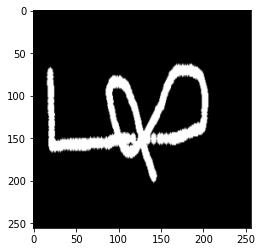

In [57]:
# show image
img = Image.fromarray(targets[4])
img = transform1(img)
img = torchvision.utils.make_grid(img)
plt.imshow(np.transpose(img, (1,2,0)))
plt.show()

In [67]:
Predictions = []
THRESHOLD = 0.8
Digital_Switch = False # Whether to identify the number

for item in targets:
    img = Image.fromarray(item)

    # Step 1: Start with Siamese Network
    img256 = transform1(img)
    img256 = img256.unsqueeze(0) # 增加一个个数维度
    Prediction_vector1, _ = model1(img256, img256)
    distance_list = get_distance(Prediction_vector1, Mean_Vectors)
    Prediction_Class = np.argmin(distance_list)
    Prediction_Dissimilarity = np.min(distance_list)

    # print(Prediction_vector.shape)
    # print(distance_list)
    # print(Prediction_Class, Prediction_Dissimilarity)

    # Greater than the threshold
    if Prediction_Dissimilarity < THRESHOLD:
        # Step 2: Check by CNNs
        Prediction_vector2 = model2(img256)
        Check_Prediction_Class = np.argmax(Prediction_vector2.detach().numpy())
        
        ########################### Output Processing ###########################
        if Prediction_Class == Check_Prediction_Class:
            Digital_Switch = False
            Predictions.append(Class_name[Prediction_Class])
            if Prediction_Class == 4:
                Digital_Switch = True
            continue

    
    if Digital_Switch:
        # Step 2: identify the number 
        img28 = transform2(img)
        img28 = img28.unsqueeze(0) # 增加一个个数维度
        Prediction_number_vector = model3(img28)
        number = np.argmax(Prediction_number_vector.detach().numpy())
        Predictions.append(number)

    Predictions.append("?")

In [68]:
Predictions

['U2661', 'U2662', '?', '?', '?']